In [1]:
%%capture
%pip install plotly
%pip install sklearn
%pip install scikit-learn
%pip install matplotlib
%pip install wordcloud

In [2]:
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from main import count_occurrences
from data_exploration_functions import  conllu_dict, wordclouds_by_tag, wordcloud_of_words_or_sentences, counts_for_files, sentence_length_boxplot, plot_subsets_comparison, transition_matrix, get_tags_predictions

# OUT-OF-DOMAIN RESULTS

## ENGLISH
### DATASET ANALYSIS

The Out of Domain English dataset we have chosen is the "Tweebsnk v2" avaliable in this [github](https://github.com/Oneplus/Tweebank/tree/dev). This is a collection of English tweets annotated with POS tags, following the Universal Dependencies. The dataset is already divided in train, dev and test sets. 

In [3]:
dataset_path = "UD-Data/out_of_domain/English/"

counts_trains = count_occurrences('UD-Data/out_of_domain/', ['train'], write=False)
counts_dev = count_occurrences('UD-Data/out_of_domain/', ['dev'], write=False)
counts_test = count_occurrences('UD-Data/out_of_domain/', ['test'], write=False)
total_counts = count_occurrences('UD-Data/out_of_domain/', ['train', 'dev', 'test'], write=False)

info_train, i = conllu_dict(f'{dataset_path}/en-ud-tweet-train.conllu') 
info_dev, i = conllu_dict(f'{dataset_path}/en-ud-tweet-dev.conllu', i+1) 
info_test, i = conllu_dict(f'{dataset_path}/en-ud-tweet-test.conllu', i+1) 
all_info = {**info_train, **info_dev, **info_test}

6711
3675
15839
5508
6711
3675
5508
15839


Since the corpus could be used as a training dataset, they are divided in 3 files, but here we will analyze it as a single file. The initial division of the sentences and words was the following one:

* en-ud-tweet-train.conllu: 1,639 tweets (24,753 words)
* en-ud-tweet-dev.conllu: 710 tweets (11,742 words)
* en-ud-tweet-test.conllu: 1,201 tweets (19,112 words)

In total there are 3550 sentences or 55607 tagged words. 

In [4]:
train_words = 0
dev_words = 0
test_words = 0
train_lengths = []
dev_lengths = []
test_lengths = []

for doc in info_train.values():
    if isinstance(doc, dict):
        train_lengths.append(len(doc['sentence']))
        train_words += len(doc['sentence'])
for doc in info_dev.values():
    if isinstance(doc, dict):
        dev_lengths.append(len(doc['sentence']))
        dev_words += len(doc['sentence'])
for doc in info_test.values():
    if isinstance(doc, dict):
        test_lengths.append(len(doc['sentence']))
        test_words += len(doc['sentence'])

print("Number of sentences:", len(info_train)+len(info_dev)+len(info_test)-3)
print("Number of words:", test_words + dev_words + train_words)

Number of sentences: 3547
Number of words: 55607


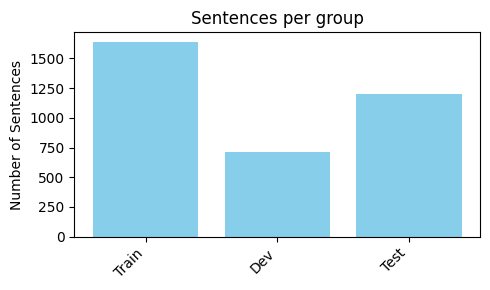

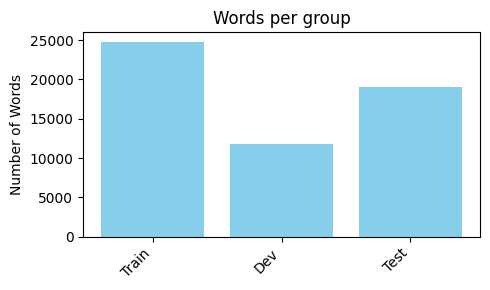

In [5]:
counts_for_files(['Train', 'Dev', 'Test'], [len(info_train)-1, len(info_dev)-1, len(info_test)-1])    
counts_for_files(['Train', 'Dev', 'Test'], [train_words, dev_words, test_words], "Words")  

As anticipated, since this is a Twitter corpus, sentence lengths only vary from 1 to 40 words, with an average of 15 words per sentence. The outliers when taking into account the tweet length, only pass the length of 40 words by a couple of tokens and there is only a couple of those sentence among all, so it is not a big deal. This distribution is clearly illustrated in the boxplots below:

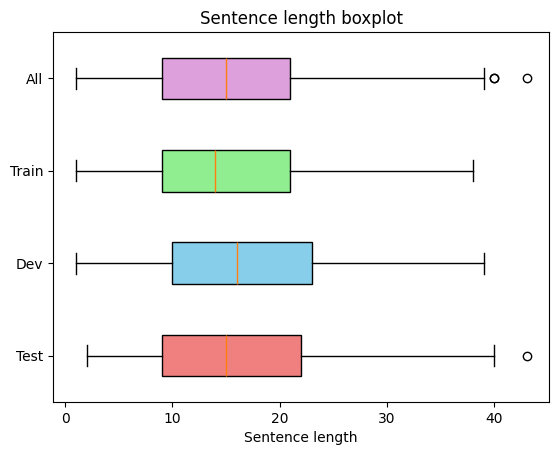

In [6]:
sentence_length_boxplot(['Test', 'Dev', 'Train', 'All'], [test_lengths, dev_lengths, train_lengths, train_lengths+dev_lengths+test_lengths])

As expected, the predominant words in the dataset are those related to Twitter, such as "RT", abbreviated words like "u", "lmao", or "lol", and terminology related to entertainment ("video", "game", etc.); all of this in a more colloquial register than in other contexts. This type of terminology is more common in the social media context, not only because the number of characters is limited (as seen in the boxplot representing the length of phrases used in each tweet), but also because the topics of interest on social media are more varied, ranging from politics to entertainment, among others.

This differs from what was seen in the training set, where, being a dataset focused on the legal field, news, and Wikipedia, more elaborate and complex terminologies are used.

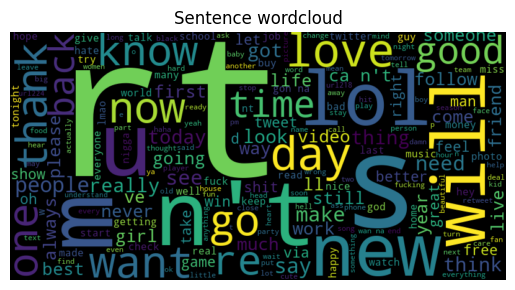

In [7]:
all_sentences = []
for i in all_info.values():
    all_sentences += [' '.join(i['sentence'])]
wordcloud_of_words_or_sentences(all_sentences)

Here can be seen all the most common words for each PoS tag. Considering that PoS tags like NOUN or VERB have a fairly concrete definition of the types of words they cover (in this case, nouns and verbs respectively), in this case, we will focus on analyzing those tags that have more open definitions, subject to interpretation:

SYM: This tag is defined by having symbols. In the case of this dataset, all special characters not categorized under any other label have been considered symbols, as well as emoticons, special characters ($, %, @...) and others.
X: This category, left open for "others", has collected words that begin with "url", "http", and other types of Twitter-specific words such as "RT".


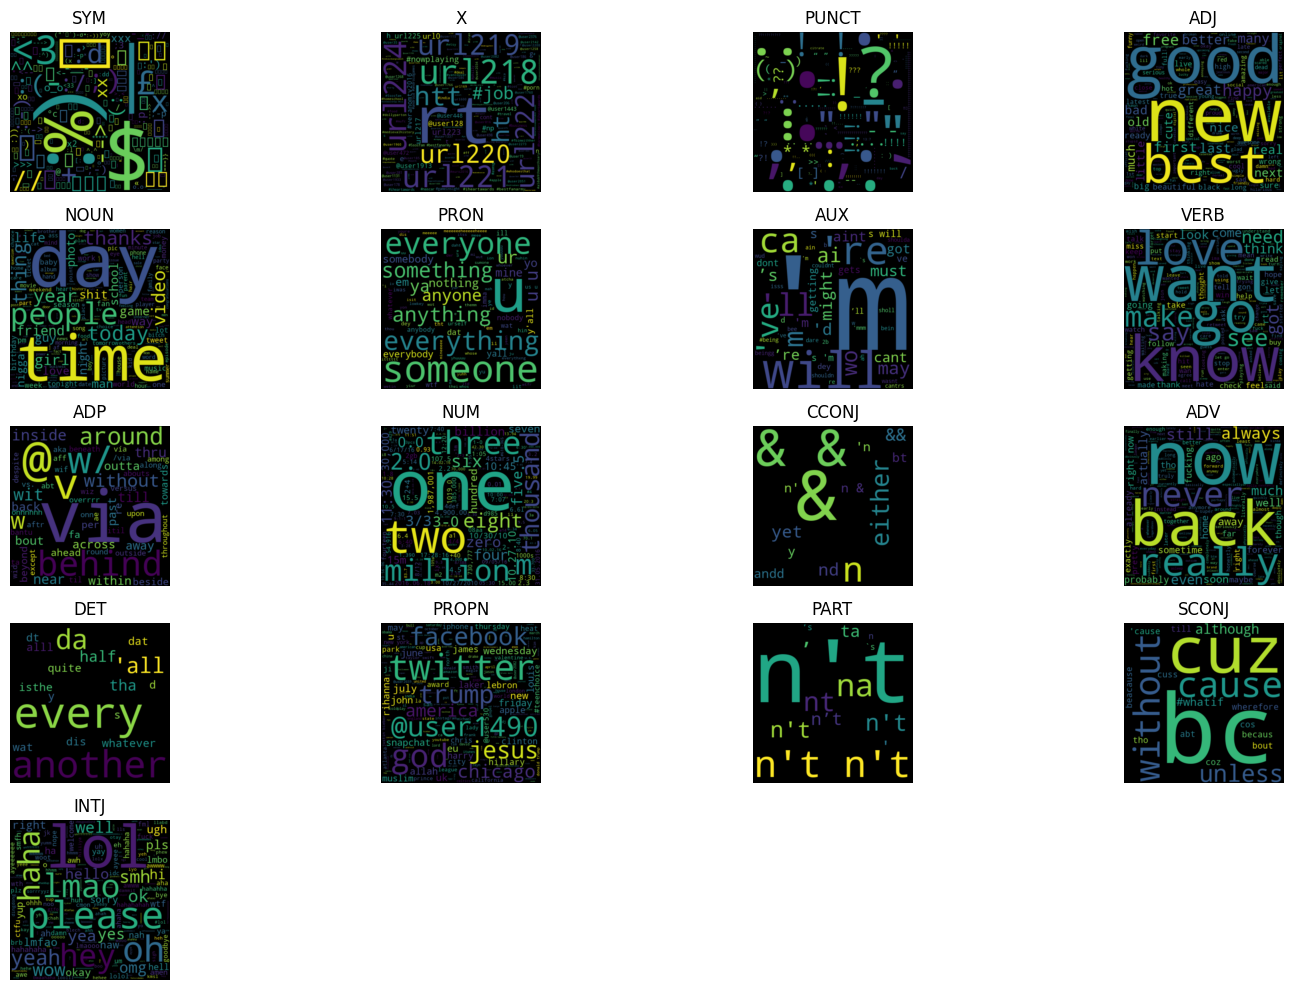

In [8]:
words_per_tag = {'SYM':[], 'X':[]}
for instance in all_info.values():
    for i, tag in enumerate(instance['tags']):
        if tag not in words_per_tag.keys():
            words_per_tag[tag] = []
        words_per_tag[tag] += [instance['sentence'][i]]
        
wordclouds_by_tag(words_per_tag)


The distribution of tags is shown in the following graph, where it is visible that the main tags are NOUN, PUNCT, VERB, and the special one X. This is expected, since the dataset is composed of tweets, where the most common words are nouns, verbs, adjectives, and pronouns. The PUNCT tag is also very common, since tweets are short and normally end with a punctuation mark or use them in between (the appearance of several punctuation marks is also common). 

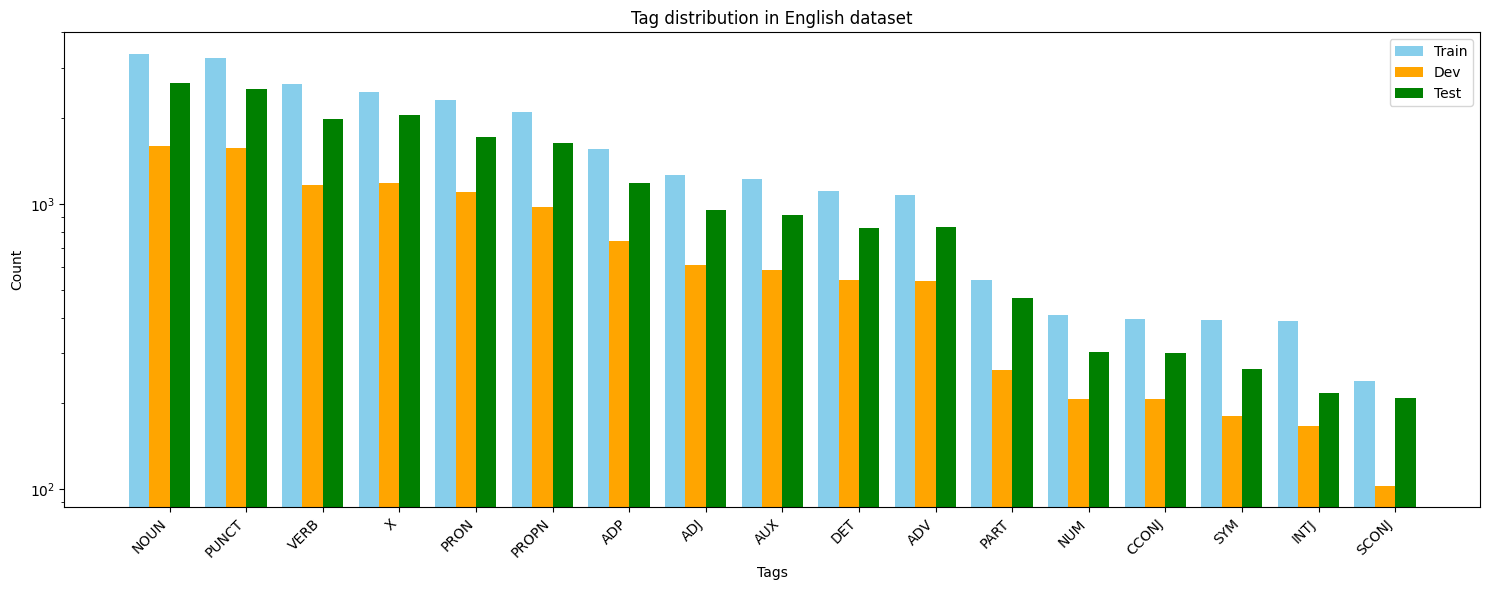

In [9]:
data = {'train' : counts_trains['English']['tags'],
        'dev' : counts_dev['English']['tags'],
        'test' : counts_test['English']['tags']}
plot_subsets_comparison(data, 'Tag distribution in English dataset')

As shown bellow the most common transitions from tag-to-tag are the X to X and NOUN to PUNCT transitions. Specially the first case is obvious since all the hashtags, urls, mentions to users (@USER) are always put together and normally at the end or the beginning of the tweet, in order to answer or to mention somebody. This also explains why are so common the X to PUNCT and X to <EOL> transitions (the ending with hashtags or mentions) or the same with NOUN to PUNCT transition (sometimes the "@USER" are also tagged as NOUN when they are used to mention someone). 

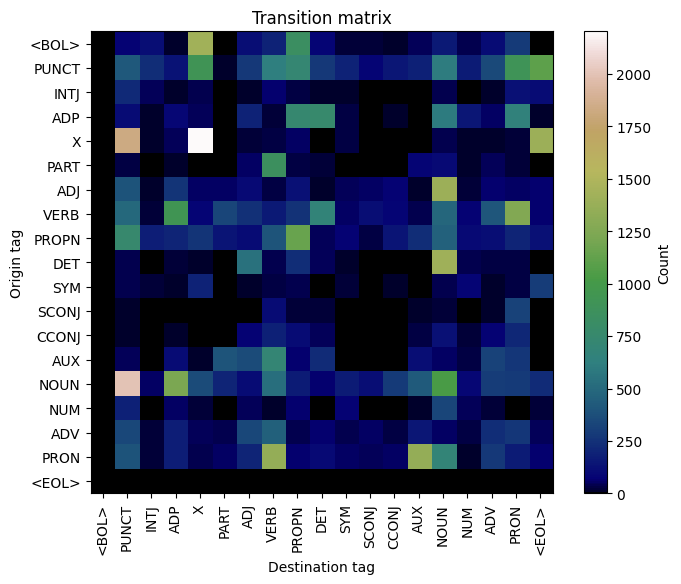

In [10]:
transitions = total_counts['English']["transitions"]
transition_matrix(transitions)

### ERROR ANALYSIS

Here, we will analyze the HMMs performance on the out-of-domain Twitter dataset. Remember that the in-domain context was about law, news and Wikipedia, so the sentence-length, type of words, tag appearance and so on, are totally different. 

The results are stored in the "output" folder, in the "od_English_predictions.jsonl" file. This file contains the tags and predictions for each sentence in the out-of-domain dataset.

In [11]:
lang = "English"
ruta_archivo = f"output/od_{lang}_predictions.jsonl"
tags_to_check = ["ADJ", "NOUN", "VERB"]
all_tags, all_predictions, errors = get_tags_predictions(ruta_archivo)
all_the_tags_avaliable = set(all_tags).union(all_predictions)


In [12]:
accuracy = accuracy_score(all_tags, all_predictions)
accuracy

0.5810868271111489

The accuracy of the model on the out-of-domain dataset is 0.58, which is still a good result considering the differences between the training and testing datasets. The confusion matrix shows that the most common errors when tagging are the following:

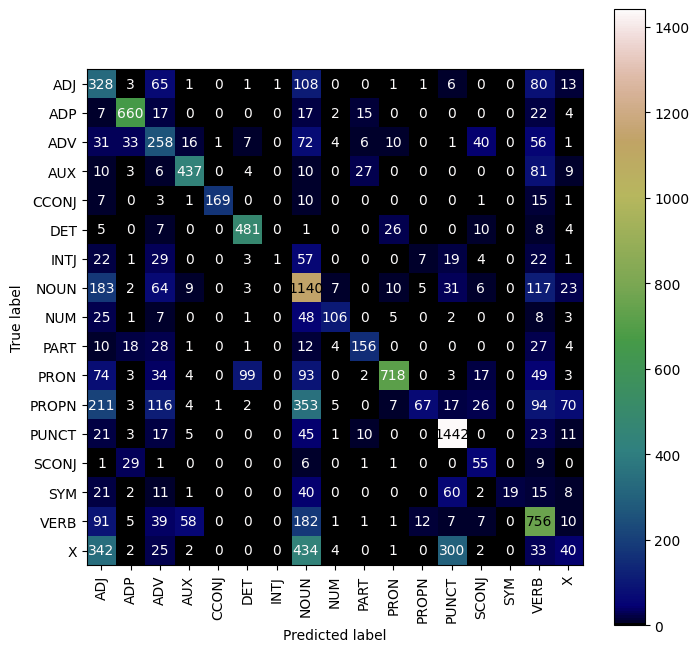

In [13]:
#create the confusion matrix
tags_set = sorted(set(all_tags))
cm = confusion_matrix(all_tags, all_predictions, labels=tags_set)
cm

#show the plot
fig, ax = plt.subplots(figsize=(8, 8))  # Adjust width and height as needed
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=tags_set)
disp.plot(cmap="gist_earth", ax=ax, xticks_rotation="vertical")

plt.show()

The model tends to infer the tags of ADJ, VERB, ADV and NOUN, confusing all types of tags with them. This may happen, because some of these are the most common tags in the Twitter dataset, and are also the type of words that may not appear in the legal or news context, since they may be words related to daily activities, more typical of social media. This also implies that a lot of the words that related to these tags may also be changed as the <UNK> token, since they do not appear in the training dataset.

This last hypothesis seems to be correct, because if we look at the most common tags for the <UNK> token in English, they almost correspond to the most predicted (incorrectly predicted) ones from the matrix, namely the tags: NOUN, VERB and ADJ.

In [14]:
for check_tag in tags_to_check:
    print(f"-------{check_tag}--------")
    for tags,value in errors.items():
        if tags.split(",")[1] == check_tag:
            # Contar la cantidad de repeticiones de cada palabra
            word_counts = Counter(value)

            # Filtrar las palabras que aparecen más de una vez
            filtered_word_counts = {word: count for word, count in word_counts.items() if count > 1}

            # Ordenar las palabras por su frecuencia de mayor a menor
            sorted_filtered_word_counts = sorted(filtered_word_counts.items(), key=lambda x: x[1], reverse=True)
            if sorted_filtered_word_counts:
                print(tags, sorted_filtered_word_counts)
                print()

-------ADJ--------
VERB,ADJ [('got', 2), ('say', 2), ('want', 2), ('go', 2), ('RT', 2), ('raise', 2), ('wan', 2)]

X,ADJ [('RT', 284), ('#iHeartAwards', 3)]

PROPN,ADJ [('East', 3), ('New', 2), ('Academy', 2), ('Jefre', 2), ('Leicester', 2)]

NOUN,ADJ [('car', 2), ('star', 2), ('back', 2), ('family', 2), ('head', 2), ('internet', 2), ('candidate', 2), ('past', 2), ('pm', 2), ('tax', 2), ('school', 2)]

PRON,ADJ [('my', 43), ('me', 9), ('u', 8), ('yo', 2)]

ADV,ADJ [('just', 3), ('How', 2), ('very', 2)]

SYM,ADJ [('$', 4), ('|', 2), ('x', 2)]

AUX,ADJ [('Ca', 2), ('ca', 2)]

NUM,ADJ [('7', 4), ('10', 3), ('K', 2)]

INTJ,ADJ [('haha', 2), ('Please', 2)]

PUNCT,ADJ [('“', 5), ('!!', 4), ('..', 2)]

PART,ADJ [("n't", 6)]

CCONJ,ADJ [('&', 6)]

ADP,ADJ [('via', 3), ('v', 2)]

-------NOUN--------
PROPN,NOUN [('Wednesday', 5), ('City', 4), ('Clinton', 2), ('CA', 2), ('Jesus', 2), ('Heat', 2), ('God', 2), ('Geo', 2), ('Bruins', 2), ('Show', 2), ('Monroe', 2), ('PST', 2), ('NC', 2), ('Chicago',

If we check the tags and words that were misclassified, we can see that the most common errors are the following:
* When predicting ADJ instead of the correct tag, the most common error is to do it with a NOUN, taking into account that these type of words tend to appear one next to the other, the mistake is not that big. Also, a lot of words being misclassified as ADJ are actually the <UNK> tokens ('Ca', '#iHeartAwards'...), which means that the model has not seen them before, and threfore, classifies taking into account the probability of an <UNK> word, not the actual one.
* The same happens with the NOUN tag. A lot of <UNK> words are misclassified as NOUN, so they may be classified relying on the previous tag, more than taking into account the word itself. Also, the most common mistake here is to classify a PROPN as a NOUN, which is not a big mistake, since they are both nouns, but the PROPN tag is more specific.
* Lastly, and similar to the NOUN tag case, the VERB tag is used to classify a lot of <UNK> words, and also the most common mistake is to classify an AUX as a VERB, which is not a big mistake, since the AUX tag is mostly related to the VERB tag.

## SPANISH
### DATASET ANALYSIS

The Out of Domain Spanish dataset we have chosen is the "xLiMe Twitter Corpus" avaliable in this [github](https://github.com/lrei/xlime_twitter_corpus/tree/master). This is a collection of Spanish tweets annotated with PoS tagging. Since the data was annotated in a txt, only using the word and the tag, we had to put it in the Universal Dependencies format ourselves.

In [15]:
total_counts_es = count_occurrences('UD-Data/out_of_domain/', ['dev'], write=False)
all_info_es, _ = conllu_dict(f'UD-Data/out_of_domain/Spanish/es-tweets-dev.conllu') 

3675
15839


The dataset had only one file this time, in which the number of sentences and words was the following:
* Number of sentences: 7668
* Number of words: 133185

In [16]:
words = 0
lengths = []

for doc in all_info_es.values():
    if isinstance(doc, dict):
        lengths.append(len(doc['sentence']))
        words += len(doc['sentence'])

print("Number of sentences:", len(all_info_es))
print("Number of words:", words)

Number of sentences: 7668
Number of words: 133185


In this case too, the sentence lengths are quite short, with an average of 17 words per sentence and a maximum of 40 words in mostly all of the cases. However, here the outliers when taking into account the tweet length, not only have a bit more than 40 words as in the English dataset, but can arrive to 60 words too. Nevertheless, as in English, these outliers are only 2 out of all the sentences, so it is not a big aspect to consider. This distribution is clearly illustrated in the boxplots below:

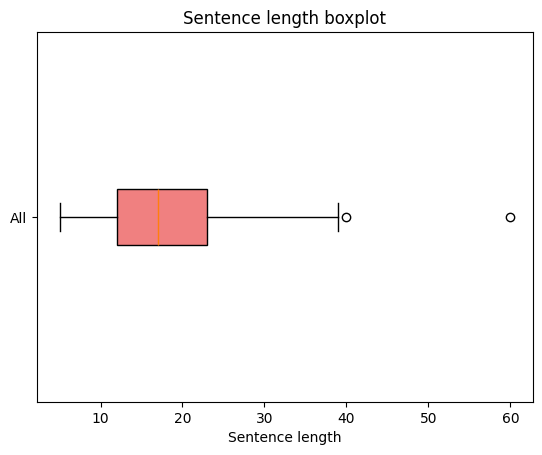

In [17]:
sentence_length_boxplot(['All'], [lengths])

Once again, the most prominent words, similar to those in the English tweet dataset, are those related to Twitter, such as 'RT', abbreviations like 'lmrei', and common everyday terms, among others. This is expected, as despite the language shift, the dataset remains rooted in Twitter, where the topics of discussion and debate are consistent. 

In this case, we have selected larger words to have a better view of their appearances in the data.


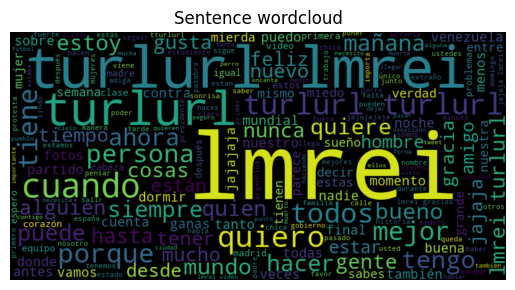

In [18]:
all_sentences_es = []
for i in all_info_es.values():
    all_sentences_es += [' '.join(i['sentence'])]
wordcloud_of_words_or_sentences(all_sentences_es, min_words=5)

Also, the meaning given to the X and SYM tags remains the same in comparison to the English dataset, so the wordclouds for these tags are similar.

Apoint to mention here is that in the tags of this dataset, the AUX and PROPN do not appear here. The reason for this is that, since it was annotated in PoS tagging, but not following the Universal Dependencies, the tags at first were different. In some cases, it was enough to change the name of the tags (for example, the tag DETERMINER was replaced with the tag DET), but some pairs of tags were mixed in a single one. This was the case for the following tags:

* SCONJ and CCONJ were together in the tag CONJ (this was succesfully separated)
* NOUN and PROPN are still, together as NOUN
* AUX and VERB are together in the tag VERB

Since we could not separate them in the same way as the others, we decided to leave them as they were, since the meaning of the tags is similar and the model may be able to differentiate them.

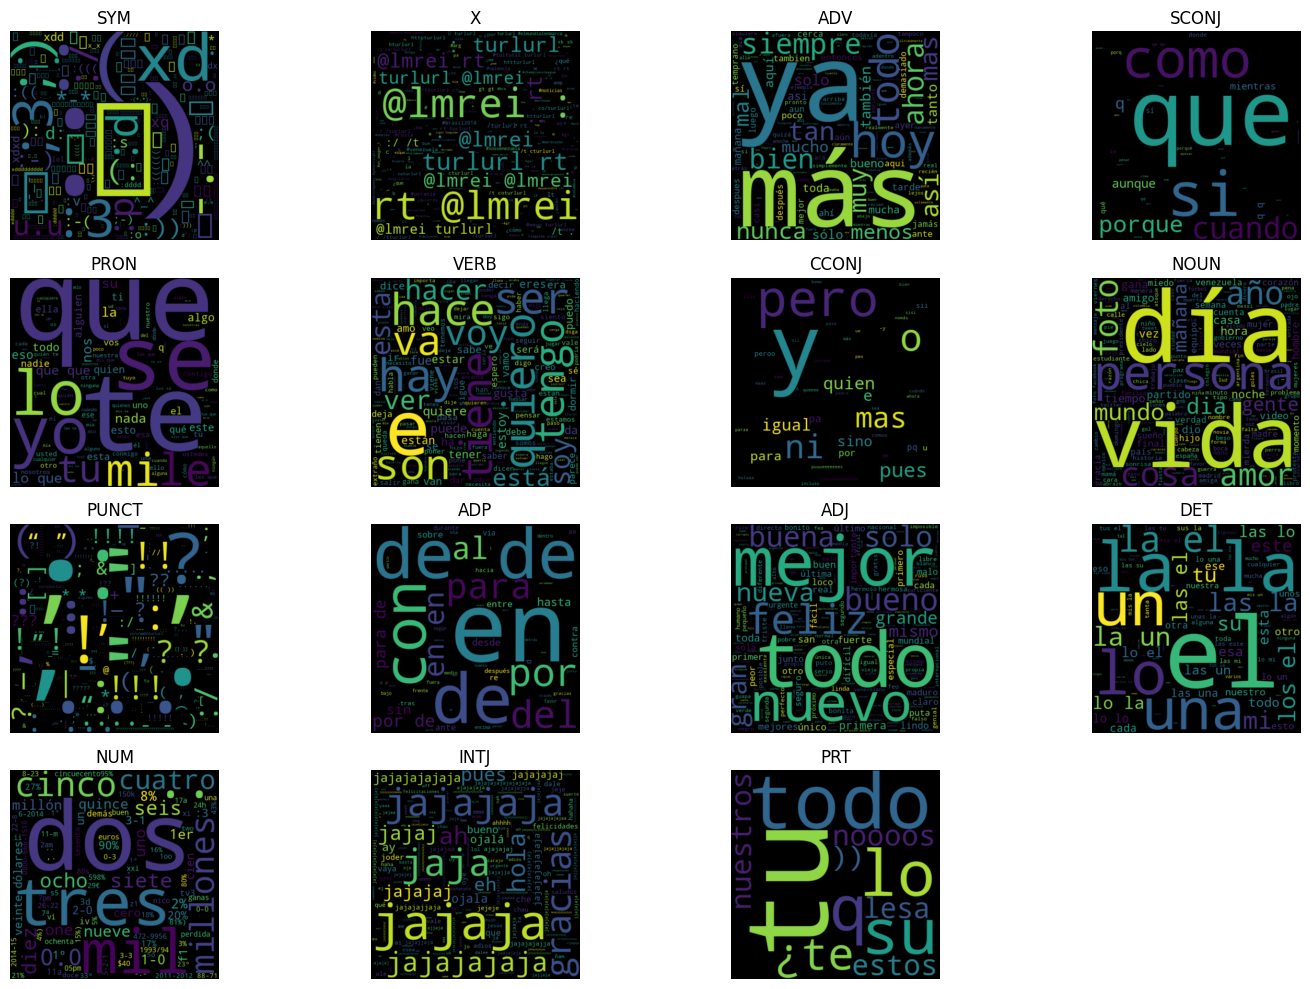

In [19]:
words_per_tag_es = {'SYM':[], 'X':[]}
for instance in all_info_es.values():
    for i, tag in enumerate(instance['tags']):
        if tag not in words_per_tag_es.keys():
            words_per_tag_es[tag] = []
        words_per_tag_es[tag] += [instance['sentence'][i]]
        
wordclouds_by_tag(words_per_tag_es)

The distribution of tags is shown in the following graph, where it is visible that the main tags are the same as in the English dataset.

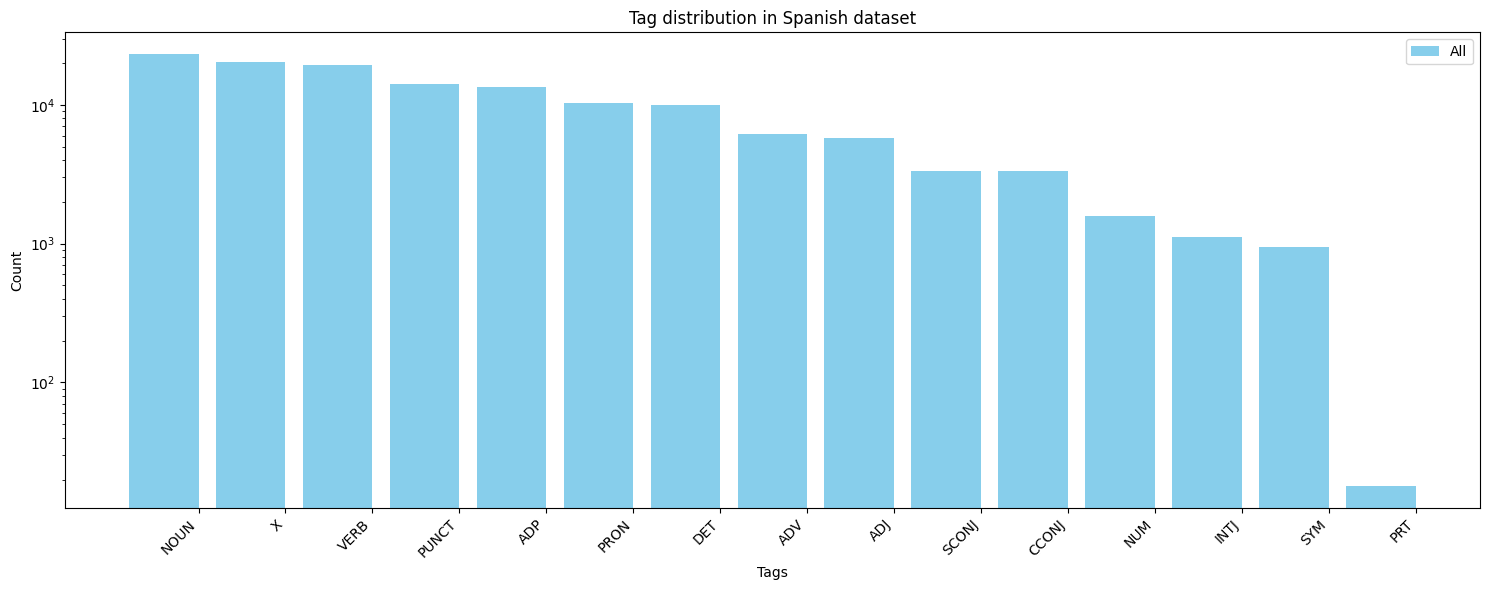

In [20]:
data_es = {'All' : total_counts_es['Spanish']['tags']}
plot_subsets_comparison(data_es, 'Tag distribution in Spanish dataset')


As shown bellow, once again one of the most common transitions from tag-to-tag is the X to X, for the same reason as before. 
 
In this case, the second most common transition is however the DET to NOUN one, which is also expected, since the determiners are always before the nouns in the sentences. The third most common transition is the NOUN to PUNCT one, which is also expected, for the reasons given before (here some users are also taken into consideration as PROPN, but here as that tag does not exist they would be taken into consideration as NOUN).

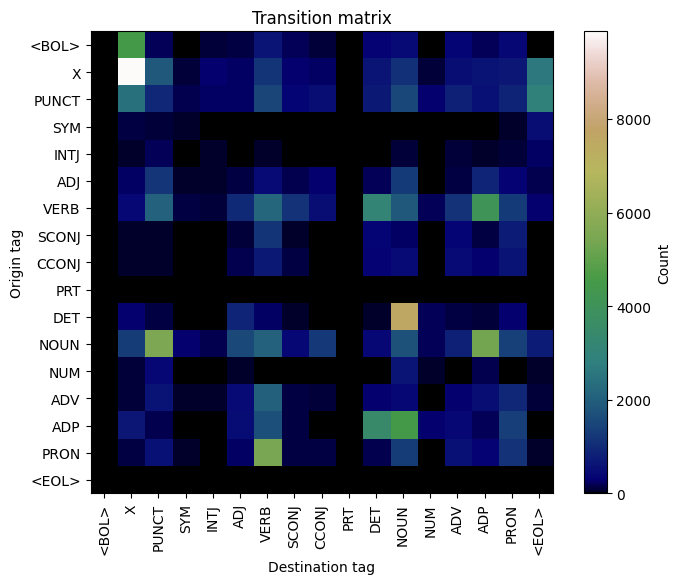

In [21]:
transitions_es = total_counts_es['Spanish']["transitions"]
transition_matrix(transitions_es)

### ERROR ANALYSIS

Here, we will analyze the HMMs performance on the out-of-domain Twitter dataset. Remember that the in-domain context was about news only, but as before, the sentence-length, type of words, tag appearance and so on, are totally different. 

The results are stored in the "output" folder, in the "od_Spanish_predictions.jsonl" file. This file contains the tags and predictions for each sentence in the out-of-domain dataset.

In [22]:
lang = "Spanish"
ruta_archivo = f"output/od_{lang}_predictions.jsonl"
all_tags, all_predictions, errors = get_tags_predictions(ruta_archivo)
all_the_tags_avaliable = set(all_tags).union(all_predictions)

accuracy = accuracy_score(all_tags, all_predictions)
accuracy

0.6500431730299959

As in the previous language, the accuracy of the HMM is quite high considering the drastic change in the domain (from news to twitter), being around 0,65. The results here are quite good in comparison to the English dataset, since even if the training dataset is 4 times bigger, there are 2 tags missing in the out-of-domain dataset, being classified as others, since the Spanish dataset was not tagged following Universal Dependencies from the beginning. And despite this, the model is able to classify the tags with a good accuracy (maybe better if we analyzed further the AUX and PROPN tags cases).

The confusion matrix shows that the most common errors when tagging are the following:

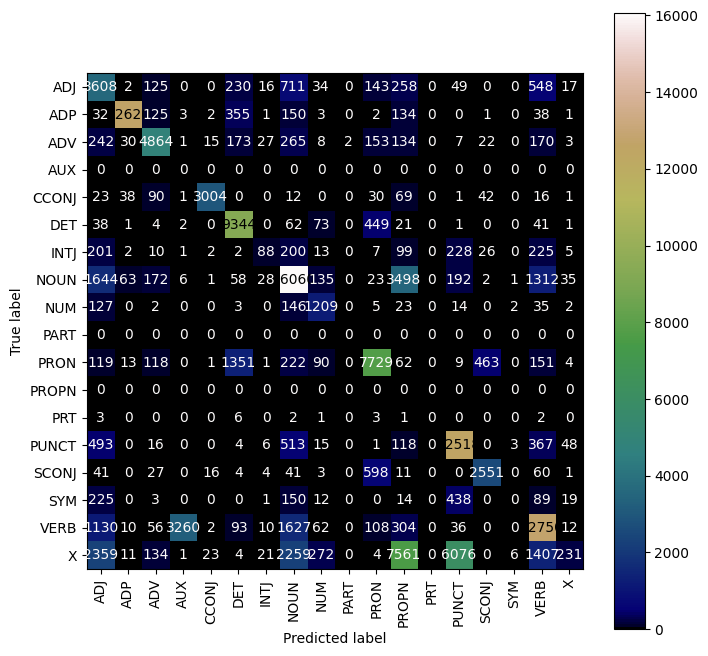

In [23]:
#create the confusion matrix
tags_set = sorted(set(all_the_tags_avaliable))
cm = confusion_matrix(all_tags, all_predictions, labels=tags_set)
cm

#show the plot
fig, ax = plt.subplots(figsize=(8, 8))  # Adjust width and height as needed
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=tags_set)
disp.plot(cmap="gist_earth", ax=ax, xticks_rotation="vertical")

plt.show()

As expected, the confusion with the labels is similar to the one in the English dataset, predicting most of the times the ADJ, NOUN and VERB tags when they are not the actual tags. This is, as in the previous case related to the <UNK> words' tag distribution, which coincides with the most incorrectly predicted tags in the out-of-domain Spanish dataset. Also, as it was obvious, a lot of NOUN tags are being classified as PROPN, since the PROPN tag does not exist in this dataset, but this may not be a mistake itself of the model, but of the out-of-domain data. The same happens with the AUX tag, that is being used to classify a lot of VERB tags, which is not a big mistake (or maybe it is not), since the AUX tag is mostly related to the VERB tag.

In [24]:
for check_tag in tags_to_check:
    print(f"-------{check_tag}--------")
    for tags,value in errors.items():
        if tags.split(",")[1] == check_tag:
            # Contar la cantidad de repeticiones de cada palabra
            word_counts = Counter(value)

            # Filtrar las palabras que aparecen más de una vez
            filtered_word_counts = {word: count for word, count in word_counts.items() if count > 1}

            # Ordenar las palabras por su frecuencia de mayor a menor
            sorted_filtered_word_counts = sorted(filtered_word_counts.items(), key=lambda x: x[1], reverse=True)
            if sorted_filtered_word_counts:
                print(tags, sorted_filtered_word_counts)
                print()

-------ADJ--------
NOUN,ADJ [('Mundial', 16), ('VIDEO', 16), ('pasado', 13), ('madre', 10), ('dia', 8), ('amigo', 8), ('Mamá', 7), ('mamá', 6), ('Video', 6), ('Messi', 6), ('Neymar', 6), ('—', 6), ('Nacional', 5), ('Valencia', 5), ('chicos', 5), ('Av', 5), ('Militares', 4), ('perra', 3), ('Popular', 3), ('CooperativaTV', 3), ('curso', 3), ('corazón', 3), ('tuits', 3), ('Atlético', 3), ('venezolanos', 3), ('celosa', 3), ('pan', 3), ('Justin', 3), ('Argentina', 3), ('Gral', 3), ('muerto', 3), ('presente', 3), ('Dominicana', 3), ('Rakitic', 3), ('derecho', 3), ('lavaplatos', 2), ('Chacao', 2), ('Awards', 2), ('Alto', 2), ('secretos', 2), ('locas', 2), ('zorra', 2), ('Papi', 2), ('Internacional', 2), ('Militar', 2), ('cagaos', 2), ('Ok', 2), ('Ft', 2), ('adiós', 2), ('sueño', 2), ('aburrimiento', 2), ('VS', 2), ('Bueno', 2), ('felicidades', 2), ('Facebook', 2), ('Djokovic', 2), ('Maps', 2), ('Earth', 2), ('Norte', 2), ('palabras', 2), ('Ordaz', 2), ('bitch', 2), ('Löw', 2), ('fuego', 2), (

Same as before, if we check the tags and words that were misclassified, we can see that the most common errors are similar to the ones in the English dataset:

* When predicting ADJ instead of the correct tag, the most common error is to do it with a NOUN, however, in this case it is also common to confuse it with VERB and X tags too. Also, a lot of words being misclassified as ADJ are actually the <UNK> tokens. In Spanish, it is important to note that the same word, without any alteration, can function as different parts of speech, which can lead to confusion. Therefore, when words like 'suicida', 'conocido', and 'perdidos' are classified with the ADJ tag but actually function as verbs (VERB), it is considered an acceptable error.
* With the NOUN tag there is also a lot of confusion with the ADJ tag, and with the VERB one also. However, a lot of cases are the same as the previous one, where, without having context, the word could be used in both tags without any problem, probably, leading to the confusion.
* Lastly, and similar to the NOUN and ADJ tag cases, the VERB tag is also misclassified as an ADJ or NOUN tag. 
